https://deepctr-doc.readthedocs.io/en/latest/Quick-Start.html

In [1]:
import os

DIR_DATA = os.path.join(os.environ["HOME"], "workspace/third_party/shenweichen/DeepCTR/examples")

In [2]:
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

In [3]:
data = pd.read_csv(os.path.join(DIR_DATA, './criteo_sample.txt'))

In [4]:
sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I'+str(i) for i in range(1, 14)]

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0,)
target = ['label']

In [5]:
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,0.0,3,260.0,0.0,17668.0,0.0,0.0,33.0,0.0,...,e5ba7672,87c6f83c,-1,-1,0429f84b,-1,3a171ecb,c0d61a5c,-1,-1
1,0,0.0,-1,19.0,35.0,30251.0,247.0,1.0,35.0,160.0,...,d4bb7bd8,6fc84bfb,-1,-1,5155d8a3,-1,be7c41b4,ded4aac9,-1,-1
2,0,0.0,0,2.0,12.0,2013.0,164.0,6.0,35.0,523.0,...,e5ba7672,675c9258,-1,-1,2e01979f,-1,bcdee96c,6d5d1302,-1,-1
3,0,0.0,13,1.0,4.0,16836.0,200.0,5.0,4.0,29.0,...,e5ba7672,52e44668,-1,-1,e587c466,-1,32c7478e,3b183c5c,-1,-1
4,0,0.0,0,104.0,27.0,1990.0,142.0,4.0,32.0,37.0,...,e5ba7672,25c88e42,21ddcdc9,b1252a9d,0e8585d2,-1,32c7478e,0d4a6d1a,001f3601,92c878de


In [6]:
data['label'].describe()

count    200.000000
mean       0.245000
std        0.431166
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: label, dtype: float64

In [7]:
for feat in sparse_features:
    encoder = LabelEncoder()
    # 可选 HashEncoder()
    data[feat] = encoder.fit_transform(data[feat])

In [8]:
mms = MinMaxScaler(feature_range=(0,1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [9]:
# 连续特征
dense_feat_columns = [
    DenseFeat(name=feat, dimension=1)  # dtype='float32'
    for feat in dense_features
]

# 稀疏特征
sparse_feat_columns = [
    SparseFeat(name=feat, vocabulary_size=data[feat].max() + 1, embedding_dim=4)
    for i, feat in enumerate(sparse_features)
]

# 所有特征
fixlen_feature_columns = dense_feat_columns + sparse_feat_columns

In [10]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = dense_feat_columns

In [11]:
# 所有特征名
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [12]:
# 拆成 train / test
train, test = train_test_split(data, test_size=0.2)

In [13]:
# {特征名： 特征值}
train_model_input = {name: train[name].values for name in feature_names}
test_model_input = {name: test[name].values for name in feature_names}

In [28]:
model = DeepFM(
    linear_feature_columns = linear_feature_columns,  # Linear 部分的特征
    dnn_feature_columns = dnn_feature_columns,        # DNN 特征 
    task='binary'    # "binary" for binary logloss, "regression" for regression loss
)

In [29]:
type(model)

tensorflow.python.keras.engine.functional.Functional

In [30]:
type(train[target].values)

numpy.ndarray

In [31]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=['binary_crossentropy', 'binary_accuracy']
)

In [32]:
history = model.fit(
    x=train_model_input,
    y=train[target].values,  # numpy.ndarray
    batch_size=256,
    epochs=80,
    verbose=2,
    validation_split=0.2,    # validation 不用于训练，只记录 loss 和 metrics
)

Epoch 1/80
1/1 - 3s - loss: 0.6585 - binary_crossentropy: 0.6585 - binary_accuracy: 0.6953 - val_loss: 0.6506 - val_binary_crossentropy: 0.6506 - val_binary_accuracy: 0.7812
Epoch 2/80
1/1 - 0s - loss: 0.6500 - binary_crossentropy: 0.6500 - binary_accuracy: 0.6953 - val_loss: 0.6452 - val_binary_crossentropy: 0.6452 - val_binary_accuracy: 0.7500
Epoch 3/80
1/1 - 0s - loss: 0.6432 - binary_crossentropy: 0.6432 - binary_accuracy: 0.6953 - val_loss: 0.6402 - val_binary_crossentropy: 0.6401 - val_binary_accuracy: 0.7188
Epoch 4/80
1/1 - 0s - loss: 0.6369 - binary_crossentropy: 0.6369 - binary_accuracy: 0.6953 - val_loss: 0.6349 - val_binary_crossentropy: 0.6348 - val_binary_accuracy: 0.7500
Epoch 5/80
1/1 - 0s - loss: 0.6306 - binary_crossentropy: 0.6305 - binary_accuracy: 0.7109 - val_loss: 0.6294 - val_binary_crossentropy: 0.6294 - val_binary_accuracy: 0.7500
Epoch 6/80
1/1 - 0s - loss: 0.6238 - binary_crossentropy: 0.6238 - binary_accuracy: 0.7031 - val_loss: 0.6235 - val_binary_crossen

Epoch 48/80
1/1 - 0s - loss: 5.4159e-04 - binary_crossentropy: 4.5180e-04 - binary_accuracy: 1.0000 - val_loss: 1.1217 - val_binary_crossentropy: 1.1216 - val_binary_accuracy: 0.5938
Epoch 49/80
1/1 - 0s - loss: 4.3581e-04 - binary_crossentropy: 3.4504e-04 - binary_accuracy: 1.0000 - val_loss: 1.1484 - val_binary_crossentropy: 1.1483 - val_binary_accuracy: 0.5938
Epoch 50/80
1/1 - 0s - loss: 3.5926e-04 - binary_crossentropy: 2.6760e-04 - binary_accuracy: 1.0000 - val_loss: 1.1735 - val_binary_crossentropy: 1.1734 - val_binary_accuracy: 0.5938
Epoch 51/80
1/1 - 0s - loss: 3.0323e-04 - binary_crossentropy: 2.1075e-04 - binary_accuracy: 1.0000 - val_loss: 1.1970 - val_binary_crossentropy: 1.1969 - val_binary_accuracy: 0.5938
Epoch 52/80
1/1 - 0s - loss: 2.6171e-04 - binary_crossentropy: 1.6848e-04 - binary_accuracy: 1.0000 - val_loss: 1.2189 - val_binary_crossentropy: 1.2188 - val_binary_accuracy: 0.5938
Epoch 53/80
1/1 - 0s - loss: 2.3060e-04 - binary_crossentropy: 1.3669e-04 - binary_ac

In [33]:
history_df = pd.DataFrame(history.history)

<AxesSubplot:title={'center':'Cross-entropy'}>

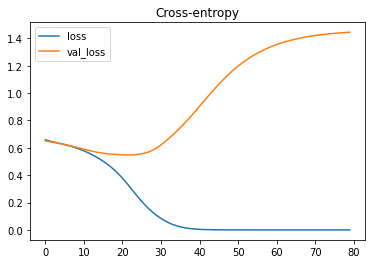

In [34]:
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")

<AxesSubplot:title={'center':'Binary Accuracy'}>

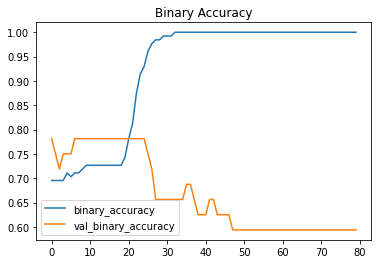

In [35]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Binary Accuracy")

In [36]:
pred_ans = model.predict(test_model_input, batch_size=256)

In [37]:
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))

test LogLoss 1.4281


In [38]:
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test AUC 0.5844


In [39]:
pred = (pred_ans > 0.5).astype(int)

In [40]:
print("test Accuracy", round(accuracy_score(test[target].values, pred), 4))

test Accuracy 0.6


In [41]:
history_df[['binary_accuracy', 'val_binary_accuracy']]

,binary_accuracy,val_binary_accuracy
0,0.695312,0.78125
1,0.695312,0.75000
2,0.695312,0.71875
3,0.695312,0.75000
4,0.710938,0.75000
...,...,...
75,1.000000,0.59375
76,1.000000,0.59375
77,1.000000,0.59375
78,1.000000,0.59375
